<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/LSTM_hurst3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ハースト指数を予測する
## （バッチ化に挑戦）
### 失敗した

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
from glob import glob
import pandas as pd
import linecache


def read_Gauss(name):
  nums = []  # 整数を入れるリスト
  with open(name, 'r', encoding='utf-8') as fin:  # ファイルを開く
    for line in fin.readlines():  # 行を読み込んでfor文で回す
        try:
            line = line.replace('\n','')
            num = float(line)  # 行を整数（int）に変換する
        except ValueError as e:
            print(e, file=sys.stderr)  # エラーが出たら画面に出力
            continue

        nums.append(num)  # 変換した整数をリストに保存する
  return (nums)


# カテゴリを配列で取得
drive_dir = "/content/drive/My Drive/python/"

categories = [name for name in os.listdir(drive_dir + 'data_gauss') if os.path.isdir(drive_dir + "data_gauss/" +name)]
print(categories)



['H=0.1', 'H=0.9', 'H=0.7', 'H=0.8', 'H=0.6', 'H=0.5', 'H=0.4', 'H=0.3', 'H=0.2']


In [56]:
import numpy as np
DAT = pd.DataFrame(np.zeros(shape=(1024, (32*9))))
i=0
for cat in categories:
    path = drive_dir + "data_gauss/" + cat + "/*.rri"
    files = glob(path)
    for text_name in files:
      data = pd.Series(read_Gauss(text_name))
      DAT.iloc[:, i] = data
      DAT.rename(columns={i: cat}, inplace=True)
      i = i+1


# データフレームシャッフル
DAT = DAT.sample(frac=1,axis=1).reset_index(drop=True)
DAT.T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
H=0.7,-0.588034,-0.287743,-0.612864,-0.619655,0.627601,0.123289,1.429318,-1.228773,0.106156,0.832035,0.841141,0.213237,1.700141,-0.897730,-0.311464,0.086907,0.544251,0.221683,-0.386928,-1.280346,0.557177,-0.049411,0.172290,-0.003512,0.115060,-0.402086,-0.112538,0.279109,-0.227215,1.310820,1.380144,1.739183,0.865346,0.921820,-0.489017,0.940501,-0.156376,0.229370,-0.299739,-0.554748,...,0.828110,0.576683,0.091132,-1.015567,-1.930997,0.272719,-0.656398,0.228674,0.715173,0.512658,-0.169764,-0.611219,-1.819088,0.596954,-0.042182,0.500645,-0.862991,-1.357412,-0.604545,-0.312486,-0.617157,0.519595,0.988267,1.350393,0.908976,0.893551,1.088291,-1.407421,-0.386190,-0.254563,-0.566499,-0.544298,-0.065700,0.478115,-1.220781,-0.668833,-0.604168,-0.212697,-1.914012,-0.249812
H=0.2,0.845461,-2.134457,0.603385,-0.495729,-0.704056,0.918272,0.517226,-1.776804,0.545644,-0.060963,1.278737,-1.287791,0.537247,0.304055,-0.146142,0.447847,0.363029,0.660639,-1.270708,0.371136,-0.258741,0.359309,-0.546128,0.655015,-0.376205,-0.697187,0.086764,0.252157,0.388421,-1.334445,0.987701,0.020077,0.837301,-1.128812,0.734057,-1.249393,0.741410,-1.014634,-0.561648,-0.569003,...,0.687570,-0.947287,1.216429,-0.581162,0.865358,0.915445,-0.775494,-0.248142,0.115697,0.874609,-2.019860,1.240208,-1.079387,0.454000,1.633866,0.374936,-1.351849,-0.233934,2.166926,-1.195369,-0.663495,-0.131335,-0.254910,-0.360757,1.710536,-0.971714,-0.179198,1.626823,-0.360994,-0.288578,0.391594,-0.522012,-0.132008,-0.263979,2.017746,-0.202105,-1.697152,0.688652,-1.242811,0.387248
H=0.1,0.735359,-0.458145,0.605607,1.097721,1.174084,-1.448871,-2.210869,2.676773,-0.878935,-0.787031,0.117229,0.242599,-0.557570,2.313303,0.010366,-2.190669,0.109482,-0.707026,1.479448,-0.933438,0.252160,-0.743883,-0.677097,1.258819,-0.477889,-1.904090,3.422584,-1.030297,0.292679,0.630351,-1.419021,0.293425,-0.090718,-0.000987,0.785013,0.890676,-0.359453,-1.414382,1.125361,0.311273,...,0.408133,1.648702,-0.261273,-0.438295,-0.703796,1.099677,-0.549911,-0.402123,0.514996,0.536853,-1.001161,-0.015065,0.539008,-0.024225,1.734411,-0.537129,-0.510876,0.059888,1.084015,-1.488814,0.126125,0.397503,-0.938776,0.106337,1.364418,0.240339,-1.908295,0.149401,0.478579,0.765899,0.103079,1.470723,-0.775111,-0.708011,0.647333,0.060977,0.775501,-1.280055,1.471662,-0.244385
H=0.8,-0.006870,-1.001835,-2.078722,-0.323067,-1.355498,-1.589519,-0.611305,-0.073338,0.529313,0.848954,-0.900225,-0.515004,-0.048927,-0.362034,-1.352163,-0.974065,-0.822506,0.755624,0.361086,0.879381,0.823688,0.589071,0.940721,0.099965,-0.379111,-0.699423,-0.827383,-0.002784,0.056848,0.091292,-0.463169,-0.001980,0.193070,-0.600625,-0.759616,-0.205024,1.299127,1.245043,-1.170399,-1.169787,...,1.360221,0.526232,-0.183582,-0.098885,1.157669,-0.803244,0.433923,-0.071947,-0.147765,-0.257753,0.589102,0.856362,0.716965,1.306454,-0.176231,-1.031076,0.554025,0.010201,-0.317939,-0.126475,-1.017969,1.299803,1.209251,-0.988085,0.619772,-0.242597,-1.353245,-1.638247,-1.483129,-0.933041,-1.978215,-0.491036,0.003471,1.726187,1.293880,2.341683,1.206171,0.940136,0.956258,1.303473
H=0.7,-0.622769,-0.928692,-0.002247,-0.169483,0.326179,0.126091,1.391152,1.860877,-0.545745,-0.629531,-0.584679,0.952096,0.933402,2.316608,0.278979,1.027313,0.104455,0.226755,0.873526,-0.255695,1.273273,-1.224300,0.872979,0.878399,0.688676,-0.426905,1.798752,0.314131,0.700635,2.093294,1.539120,0.268264,0.260109,-0.091717,-0.948666,0.314080,1.714060,2.298109,-0.336998,0.382671,...,-0.279079,-0.217160,0.940807,-0.060320,0.764533,-1.156753,0.339584,-0.967094,-0.225595,-0.891379,-1.693407,-0.051531,2.099809,-0.658460,0.276479,0.843138,0.655029,-0.054641,0.039340,0.319541,-0.920559,-0.354681,-0.740128,0.201373,1.42

In [57]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim


category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)


def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

# データフレームの形状変更・indexの要素化
df = DAT.T
df['index'] = df.index

df_label = df.loc[:, 'index']
df_data = df.drop('index', axis=1)

dlen = len(DAT.columns)  # 288
# train, test = train_test_split(df, test_size=0.3,random_state=0)
train_x, test_x, train_y, test_y = train_test_split(df_data, df_label, test_size=0.3, random_state=0)

# train_x2 = torch.LongTensor(train_x.values)
# test_x2 = torch.LongTensor(test_x.values)
train_x2 = torch.FloatTensor(train_x.values)
test_x2 = torch.FloatTensor(test_x.values)
# train_x2 = torch.cuda.LongTensor(train_x.values)
# test_x2 = torch.cuda.LongTensor(test_x.values)
train_y2, _ = pd.factorize(train_y)   # カテゴリー変数を数値に変換
test_y2, _ = pd.factorize(test_y)

train_y2 = torch.FloatTensor(train_y2)
test_y2 = torch.FloatTensor(test_y2)

# 次元を増やさないといけない？
train_x2 = train_x2.unsqueeze(2)
train_y2 = train_y2.unsqueeze(1)
test_x2 = test_x2.unsqueeze(2)
test_y2 = test_y2.unsqueeze(1)


# train_x = np.array(train.iloc[:][1:].astype('f'))
# train_y = np.array(train.iloc[:].index)
# train_y = train.iloc[:].index.to_list()
# test_x = np.array(test.iloc[:][:-1].astype('f'))
# test_y = np.array(test.iloc[:].index)



# train_y2 = category2tensor(train_y)

# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x2, train_y2)
test_dataset = TensorDataset(test_x2, test_y2)


# # データの形状を確認
# print("train_data size: {}". format(train_dataset.shape))
# print("test_data size: {}". format(test_dataset.shape))


# DataLoaderを使って、データセットを128個のミニパッチに分ける
# ミニパッチサイズを指定したデータローダを作成
train_batch = DataLoader(
    dataset = train_dataset,   # データセットの指定
    batch_size = 32,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

test_batch = DataLoader(
    dataset = test_dataset,   # データセットの指定
    batch_size = 32,   # バッチサイズの指定
    shuffle = False,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

# train_batch = train_batch.unsqueeze()

# ミニバッチデータセットの確認
for data, label in train_batch:
  print("batch data size: {}". format(data.size()))  # バッチの入力データサイズ
  print("batch label size: {}". format(label.size()))   # バッチのラベルサイズ
  break


{'H=0.1': 0, 'H=0.9': 1, 'H=0.7': 2, 'H=0.8': 3, 'H=0.6': 4, 'H=0.5': 5, 'H=0.4': 6, 'H=0.3': 7, 'H=0.2': 8}
batch data size: torch.Size([32, 1024, 1])
batch label size: torch.Size([32, 1])


In [58]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)   # inputsの最初の次元がバッチサイズとして認識される
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

        self.softmax = nn.LogSoftmax()

    # 順伝播処理はforward関数に記載
    def forward(self, embeds):
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        # embeds.size() = (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0])
        # tag_space.size() = (1 × batch_size × tagset_size)

        # softmaxに食わせて、確率として表現
        # (batch_size × tagset_size)にするためにsqueeze()する
        tag_scores = self.softmax(tag_space.squeeze())
        # tag_scores.size() = (batch_size × tagset_size)

        return tag_scores

category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)


{'H=0.1': 0, 'H=0.9': 1, 'H=0.7': 2, 'H=0.8': 3, 'H=0.6': 4, 'H=0.5': 5, 'H=0.4': 6, 'H=0.3': 7, 'H=0.2': 8}


In [59]:
# 入力次元数
EMBEDDING_DIM = 1
# 隠れ層の次元数
HIDDEN_DIM = 128
# 分類先のカテゴリの数
TAG_SIZE = len(categories)

# ネットワークのロード
# CPUとGPUのどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, TAG_SIZE).to(device)
# デバイスの確認
print("Device: {}".format(device))


# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
# loss_function = nn.NLLLoss()
loss_function = nn.MSELoss()  # 損失関数（平均二乗誤差：MSE）
# 最適化関数の定義
optimizer = optim.Adam(net.parameters())
# optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

epoch = 100

for i in range(epoch):
  all_loss = 0
  # エポックの進行状況を表示
  print('-------------------------------------')
  print("Epoch: {}/{}".format(i+1,epoch))

  # 損失の初期化
  train_loss = 0  # 学習損失
  test_loss = 0  # 評価損失

  # ---学習パート--- #
  # ニューラルネットワークを学習モードに設定
  net.train()
  # for ii in range(0,len(train_batch)):
  for j, (xx, yy) in enumerate(train_batch):
    # for data, cat in enumerate(train_batch[ii]):
        # data = train_batch.dataset
        # cat = train_batch[ii]
        # モデルが持ってる勾配の情報をリセット
        net.zero_grad()
        # tensor型に変換
        # inputs = torch.tensor(np.array(data.astype('f')))
        # inputs = torch.cuda.LongTensor(xx)
        inputs = xx.cuda()
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # inputs2 = torch.cuda.LongTensor(inputs)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        # answer = category2tensor(cat)
        # answer = category2tensor(yy.cuda())
        answer = yy.cuda()
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        train_loss += loss.item()
  
  # ミニバッチの平均の損失を計算
  batch_train_loss = train_loss / len(train_batch)
  # ---学習パートはここまで--- #

  # ---評価パート--- #
  # ニューラルネットワークを評価モードに設定
  net.eval()
  # 評価時の計算で自動微分機能をオフにする
  with torch.no_grad():
    for j, (xx, yy) in enumerate(test_batch):
  # for data, cat in enumerate(train_batch[ii]):
        # data = train_batch.dataset
        # cat = train_batch[ii]
        # モデルが持ってる勾配の情報をリセット
        # net.zero_grad()
        # tensor型に変換
        # inputs = torch.tensor(np.array(data.astype('f')))
        # inputs = torch.cuda.LongTensor(xx)
        inputs = xx.cuda()
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # inputs2 = torch.cuda.LongTensor(inputs)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        # answer = category2tensor(cat)
        # answer = category2tensor(yy.cuda())
        answer = yy.cuda()
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        # loss.backward()
        # 逆伝播でパラメータ更新
        # optimizer.step()
        # lossを集計
        test_loss += loss.item()


  # # ---学習パート--- #
  # # ニューラルネットワークを学習モードに設定
  # net.train()
  # # ミニバッチごとにデータをロードし学習
  # for data, label in train_batch:
  #   # GPUにTensorを転送
  #   data = data.to(device)
  #   label = label.to(device)

  #   # 勾配を初期化
  #   optimizer.zero_grad()
  #   # データを入力して予測値を計算（順伝搬）
  #   y_pred = net(data)
  #   # 損失（誤差）を計算
  #   loss = criterion(y_pred, label)
  #   # 勾配の計算（逆伝搬）
  #   loss.backward()
  #   # パラメータ（重み）の更新
  #   optimizer.step()
  #   # ミニバッチごとの損失を蓄積
  #   train_loss += loss.item()

  #   # ミニバッチの平均の損失を計算
  # batch_train_loss = train_loss / len(train_batch)
  # # ---学習パートはここまで--- #

  # # ---評価パート--- #
  # # ニューラルネットワークを評価モードに設定
  # net.eval()
  # # 評価時の計算で自動微分機能をオフにする
  # with torch.no_grad():
  #   for data, label in test_batch:
  #     # GPUにTensorを転送
  #     data = data.to(device)
  #     label = label.to(device)
  #     # データを入力して予測値を計算（順伝搬）
  #     y_pred = net(data)
  #     # 損失（誤差）を計算
  #     loss = criterion(y_pred, label)
  #     # ミニバッチごとの損失を蓄積
  #     test_loss += loss.item()

    
  # ミニバッチの平均の損失を計算
  batch_test_loss = test_loss / len(test_batch)
  # ---評価パートはここまで--- #

  # エポックごとに損失を表示
  print("Train_Loss : {:.2E} Test_Loss: {:.2E}".format(
      batch_train_loss, batch_test_loss))
  # 損失をリスト化して保存
  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)
print("done.")



Device: cuda
-------------------------------------
Epoch: 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train_Loss : 4.60E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 2/100


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train_Loss : 4.30E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 3/100
Train_Loss : 4.46E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 4/100
Train_Loss : 4.44E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 5/100
Train_Loss : 4.34E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 6/100
Train_Loss : 4.29E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 7/100
Train_Loss : 4.18E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 8/100
Train_Loss : 4.47E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 9/100
Train_Loss : 4.25E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 10/100
Train_Loss : 4.33E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 11/100
Train_Loss : 4.43E+01 Test_Loss: 4.01E+01
-------------------------------------
Epoch: 12/100
Train_Loss : 4.25E+01 Test_Loss: 4.01E+01
-------------------------

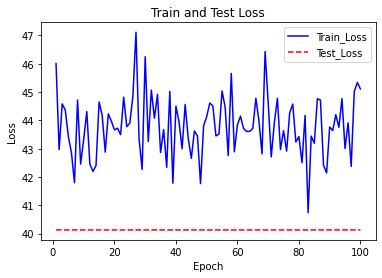

In [60]:
import matplotlib.pyplot as plt
# 損失
# 損失
fig2 = plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()
plt.show()
